# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#!pip install adjustText
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [9]:
train_data.info()
test_data.info()
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 column

clean the data and check for missing values

In [10]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2898
state              2210
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [11]:
valid_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          345
state              279
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             12
dtype: int64

In [12]:
test_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             17
dtype: int64

In [13]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2896
state              2208
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

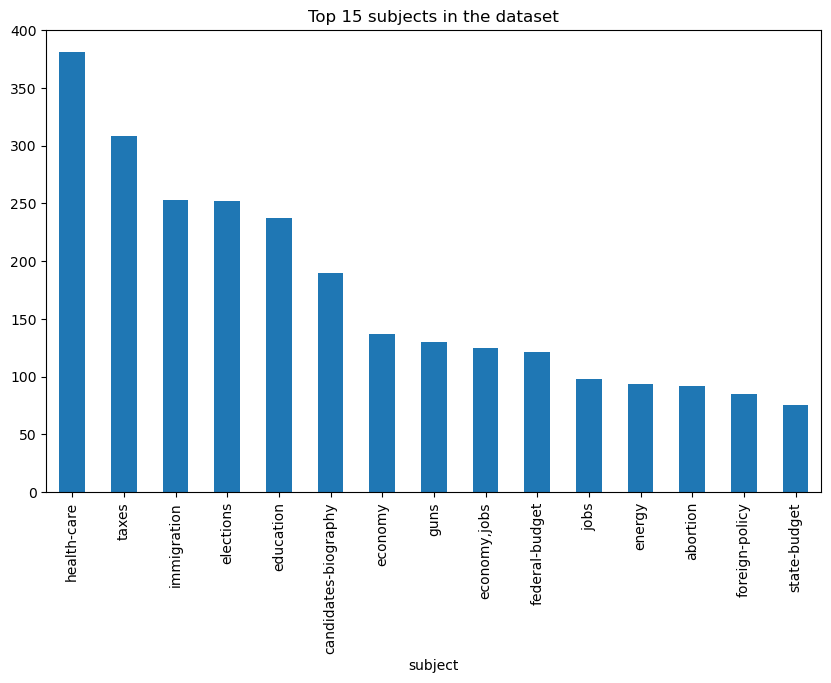

In [14]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [15]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10232,1592.json,half-true,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report"""
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate


In [16]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()

array(['a news release', 'an interview on CNN', 'a press release.', ...,
       'a recorded telephone message to Cranston residents',
       'interview on "The Colbert Report"',
       "a televised debate on Miami's WPLG-10 against Kendrick Meek."],
      dtype=object)

# Text Preprocessing
Next, preprocess the text data:

In [17]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
train_data['processed_text'] = train_data['statement'].apply(preprocess_text)
train_data['processed_job_title'] = train_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_subject'] = train_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_state'] = train_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
train_data['processed_context'] = train_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
valid_data['processed_text'] = valid_data['statement'].apply(preprocess_text)
valid_data['processed_job_title'] = valid_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
valid_data['processed_subject'] = valid_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
valid_data['processed_state'] = valid_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
valid_data['processed_context'] = valid_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:

lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply the updated function to the columns
test_data['processed_text'] = test_data['statement'].apply(preprocess_text)
test_data['processed_job_title'] = test_data['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_subject'] = test_data['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_state'] = test_data['state'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
test_data['processed_context'] = test_data['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])



# Feature Engineering for Text Data

In [20]:
# Function to average word vectors of column values
def get_average_word2vec(tokens, model, vector_size):
    if len(tokens) < 1:
        return np.zeros(vector_size)
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

In [21]:
# statement - will be used to generate new features

In [22]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=train_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
train_data['subject_embedding'] = train_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
train_data[['subject', 'subject_embedding']]


,subject,subject_embedding
0,abortion,"[0.014845564030110836, -0.058755096048116684, ..."
1,"energy,history,job-accomplishments","[0.01615387387573719, -0.09171005338430405, -0..."
2,foreign-policy,"[0.02405477687716484, -0.0897490382194519, -0...."
3,health-care,"[0.01879490166902542, -0.07883621752262115, -0..."
4,"economy,jobs","[0.02270391583442688, -0.08348675072193146, -0..."
...,...,...
10233,"animals,elections","[0.015434356406331062, -0.0836016982793808, -0..."
10234,elections,"[0.017721055075526237, -0.07851029932498932, -..."
10235,"retirement,social-security","[0.018271852284669876, -0.0798899233341217, -0..."
10236,"florida,foreign-policy","[0.018342308700084686, -0.0790228322148323, -0..."


In [23]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=valid_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
valid_data['subject_embedding'] = valid_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
valid_data[['subject', 'subject_embedding']]

,subject,subject_embedding
0,"economy,jobs","[0.0018588906386867166, 0.00018184396321885288..."
1,"obama-birth-certificate,religion","[-0.0006329974858090281, -0.001298109302297234..."
2,"campaign-finance,congress,taxes","[0.0005550389178097248, 0.001277334988117218, ..."
3,poverty,"[-6.058994767954573e-05, -0.005214277654886246..."
4,"economy,stimulus","[0.001118117943406105, 0.0007199561223387718, ..."
...,...,...
1279,"energy,oil-spill,trade","[-0.0005482457927428186, -0.000557587307412177..."
1280,candidates-biography,"[0.003805397544056177, 0.004348777234554291, -..."
1281,health-care,"[-0.00021313584875315428, -0.00021376836230047..."
1282,health-care,"[-0.00021313584875315428, -0.00021376836230047..."


In [24]:
# Subject - word to vec embedding

# Train a Word2Vec model on the processed subjects
subject_model = Word2Vec(sentences=test_data['processed_subject'], vector_size=200, window=10, min_count=1, workers=4)


# Apply the function to the 'processed_subject' column and save the embedding as a list
vector_size = subject_model.vector_size
test_data['subject_embedding'] = test_data['processed_subject'].apply(lambda x: get_average_word2vec(x, subject_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
test_data[['subject', 'subject_embedding']]


,subject,subject_embedding
0,immigration,"[2.6518007416598266e-06, 0.0007920952630229294..."
1,jobs,"[-0.004852422513067722, 0.0041798753663897514,..."
2,"military,veterans,voting-record","[-0.0006065964698791504, -0.000131508801132440..."
3,"medicare,message-machine-2012,campaign-adverti...","[-0.0005765120731666684, 2.0309118553996086e-0..."
4,"campaign-finance,legal-issues,campaign-adverti...","[0.0003711914469022304, 0.0002598663268145174,..."
...,...,...
1262,education,"[0.00344363902695477, -0.0011048623127862811, ..."
1263,"civil-rights,crime,criminal-justice","[0.0014450311427935958, -0.001650008256547153,..."
1264,"bipartisanship,congress,foreign-policy,history","[-0.0006079411832615733, -0.000755054410547018..."
1265,"environment,government-efficiency","[0.0006841374561190605, -0.0015486160991713405..."


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


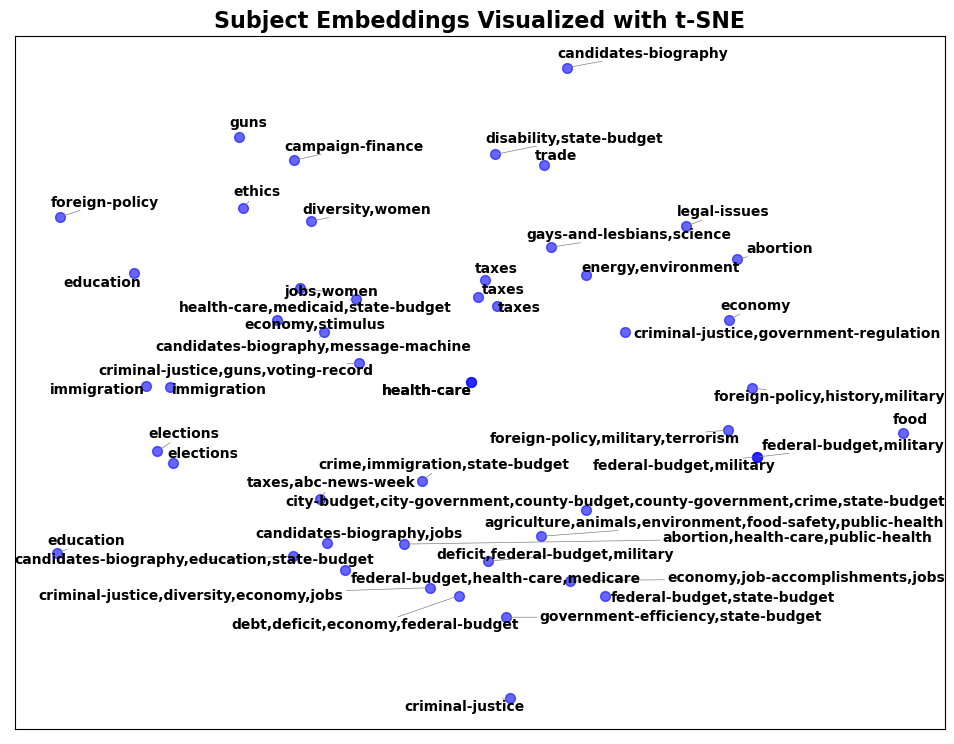

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
!pip install adjustText
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['subject_embedding'].tolist())
subjects_filtered = train_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit inside the X axis
Some labels are too long, can't fit ins

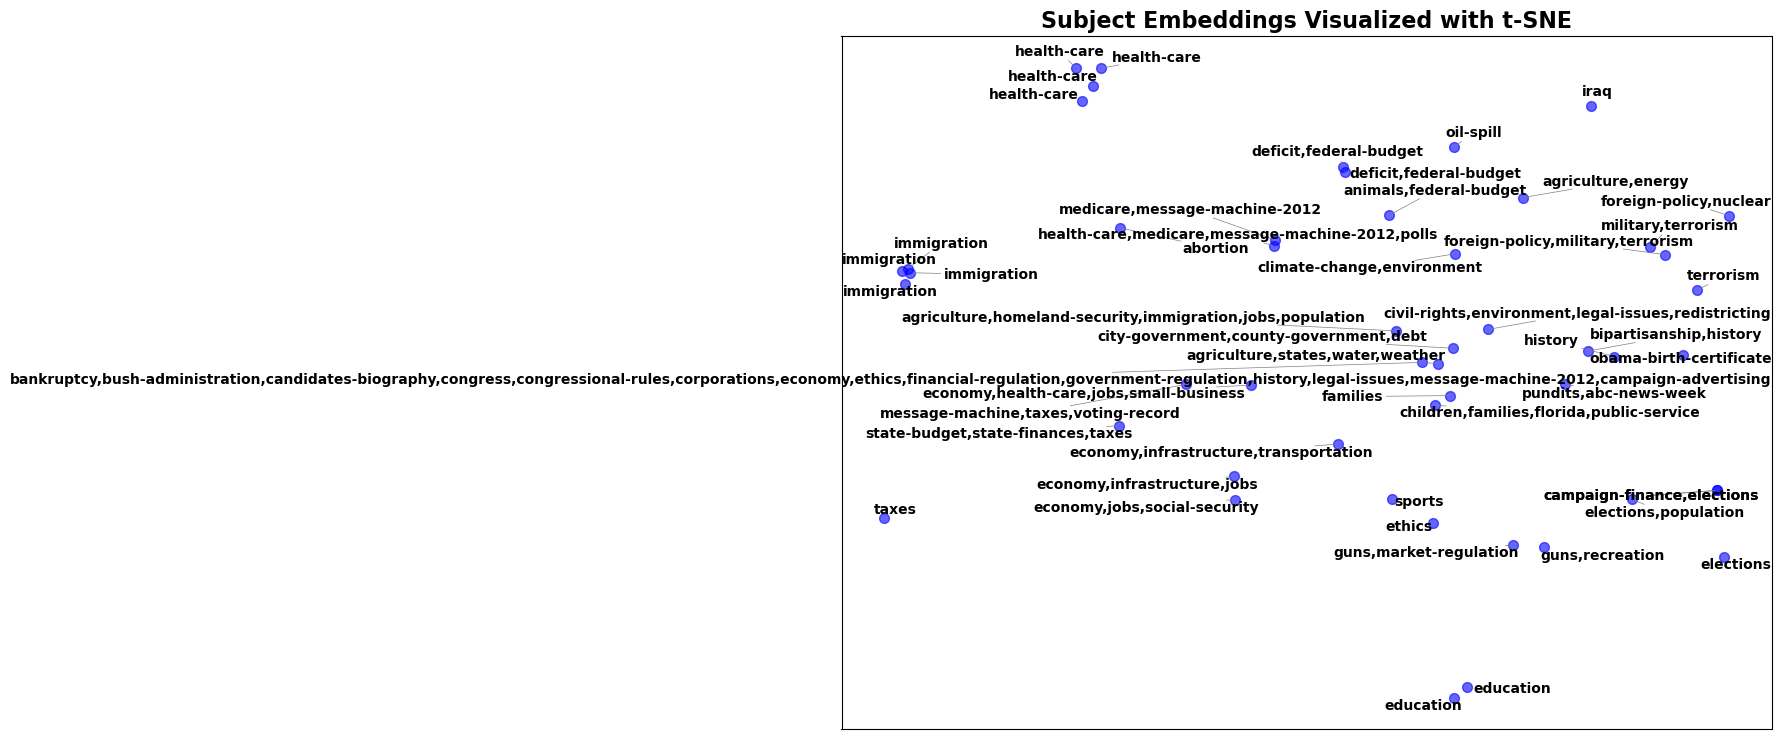

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
!pip install adjustText
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(valid_data['subject_embedding'].tolist())
subjects_filtered = valid_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


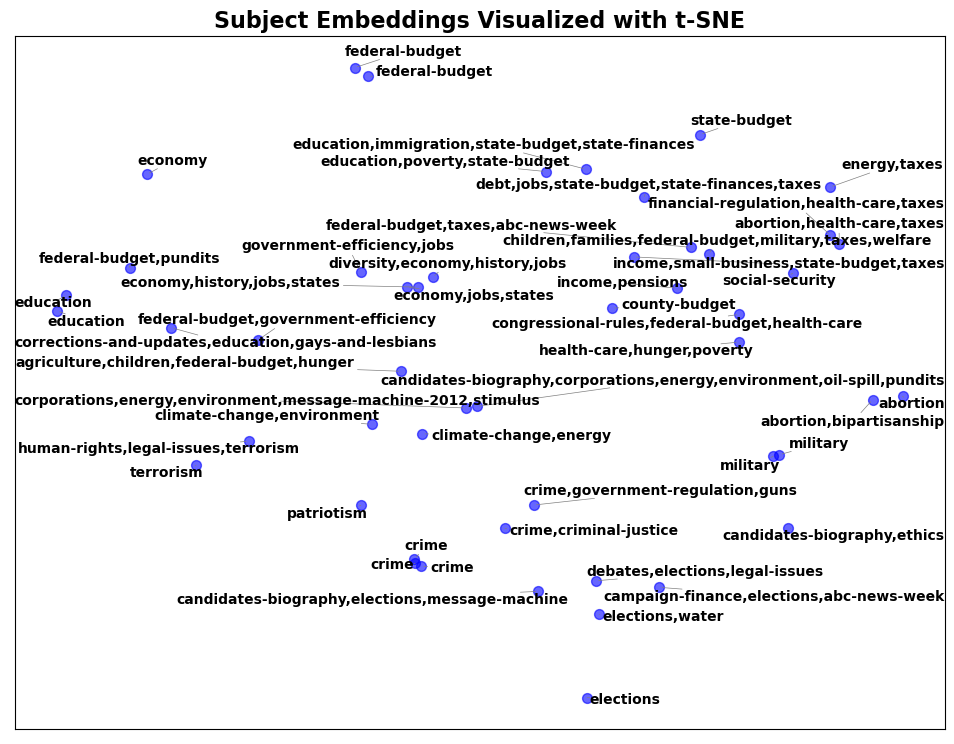

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(test_data['subject_embedding'].tolist())
subjects_filtered = test_data['subject'].values  # Use 'subject' instead of embeddings for text

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Reduce figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], subjects_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Subject Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [28]:
# speaker - dont use it and use counts of the speaker labels

# Feature Engineering: Job Title Embeddings
Train a Word2Vec model on the job titles:

,job_title,job_title_embedding
0,State representative,"[-0.00015094451373443007, -0.05562728643417358..."
1,State delegate,"[-0.002310887211933732, -0.034529440104961395,..."
2,President,"[0.013286096043884754, -0.10003895312547684, -..."
3,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


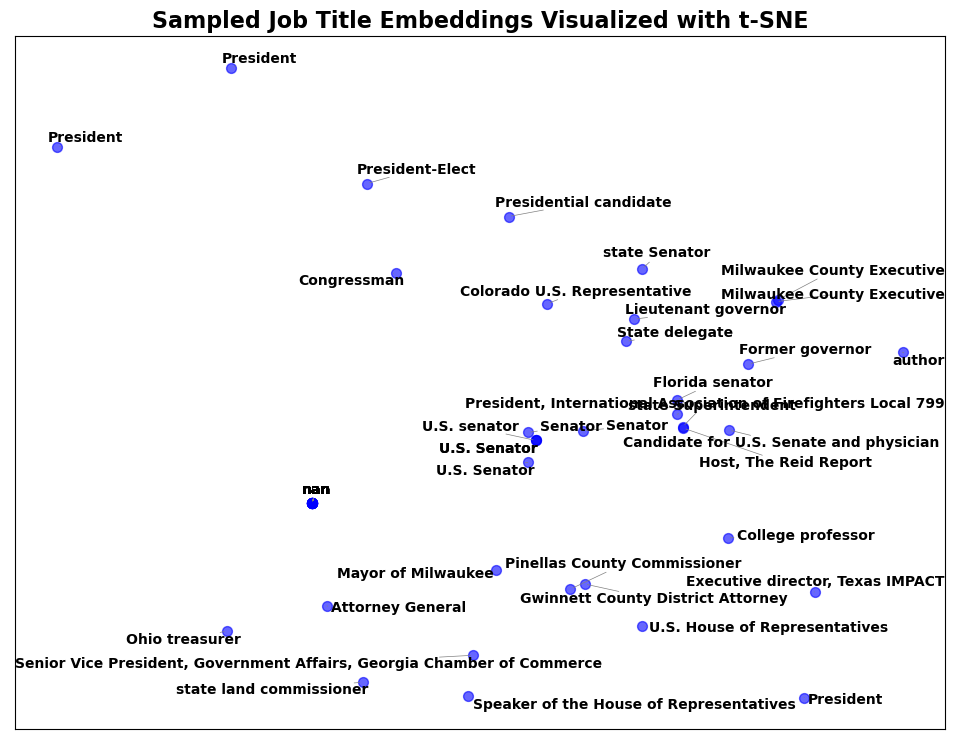

In [29]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=train_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
train_data['job_title_embedding'] = train_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(train_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(train_data['job_title_embedding'].tolist())
job_titles_filtered = train_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


,job_title,job_title_embedding
0,U.S. Representative,"[-0.0035752630792558193, 0.0003819288976956159..."
1,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,U.S. representative,"[-0.0035752630792558193, 0.0003819288976956159..."
3,Member of the State Board of Higher Education,"[-0.0007965241675265133, 0.001911364495754242,..."
4,President,"[0.004058875609189272, -0.00234767678193748, -..."


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


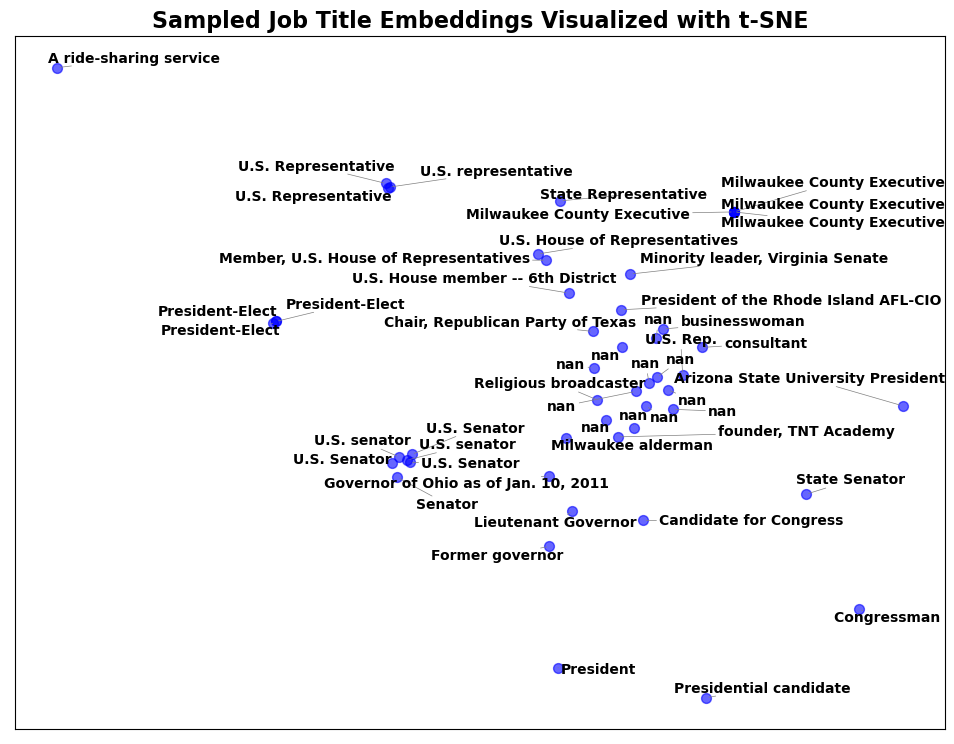

In [30]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=valid_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
valid_data['job_title_embedding'] = valid_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(valid_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(valid_data['job_title_embedding'].tolist())
job_titles_filtered = valid_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


,job_title,job_title_embedding
0,Governor,"[1.6217045413213782e-05, 0.001320246490649879,..."
1,State representative,"[0.00021882832515984774, -0.000964917242527008..."
2,President-Elect,"[0.0006500834133476019, -0.00490215141326189, ..."
3,consultant,"[0.002170220483094454, 0.003386626485735178, 0..."
4,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


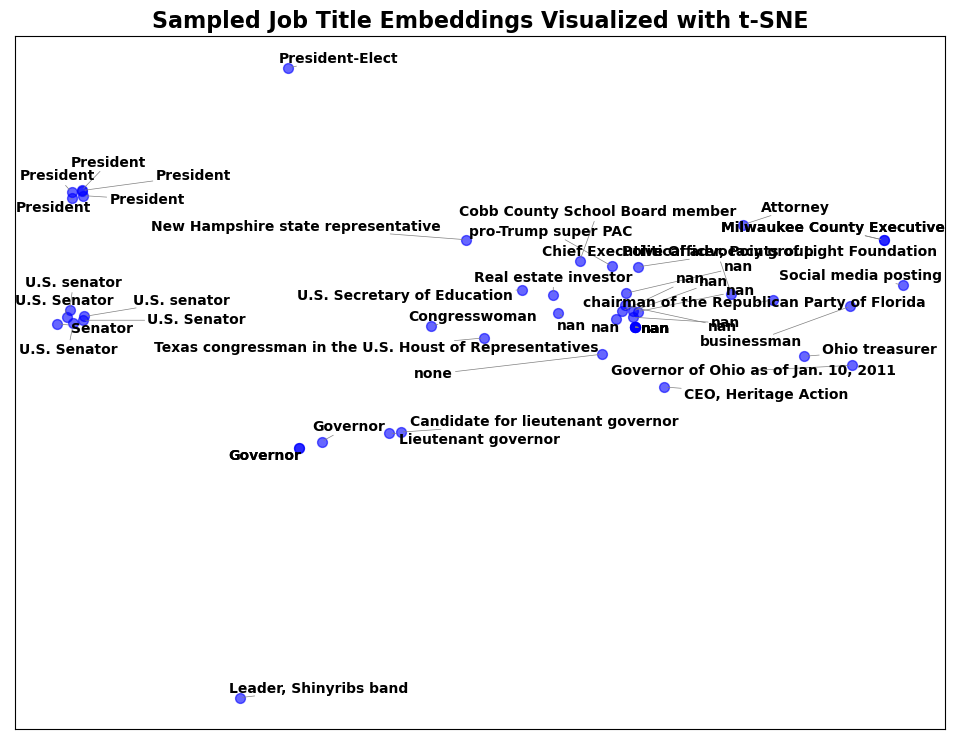

In [31]:
# job_title - word to vec embedding

# Train a Word2Vec model on the processed job titles
job_title_model = Word2Vec(sentences=test_data['processed_job_title'], vector_size=200, window=10, min_count=1, workers=4)

# Apply the function to the 'processed_job_title' column and save the embedding as a list
vector_size = job_title_model.vector_size
test_data['job_title_embedding'] = test_data['processed_job_title'].apply(lambda x: get_average_word2vec(x, job_title_model, vector_size).tolist())

# Display the first few rows to verify the embeddings
display(test_data[['job_title', 'job_title_embedding']].head())

# Visualize the embeddings using t-SNE

# Extract the embeddings and job titles after filtering
embeddings_filtered = np.array(test_data['job_title_embedding'].tolist())
job_titles_filtered = test_data['job_title'].values  # Use 'job_title' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with job titles for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], job_titles_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Sampled Job Title Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


In [32]:
# state 
# print all the states in the dataset and the number of times they appear
train_data['state'].value_counts()
# chose not to use this data.

state
Texas             1009
Florida            997
Wisconsin          713
New York           657
Illinois           556
                  ... 
Qatar                1
ohio                 1
Virginia             1
United Kingdom       1
Rhode Island         1
Name: count, Length: 83, dtype: int64

In [33]:
# state 
# print all the states in the dataset and the number of times they appear
test_data['state'].value_counts()
# chose not to use this data.

state
Texas                   124
Florida                 117
Wisconsin               101
New York                 85
Ohio                     68
Illinois                 68
Georgia                  56
Virginia                 51
Rhode Island             42
Oregon                   38
New Jersey               30
Arizona                  24
Massachusetts            22
Pennsylvania             15
Kentucky                 13
Delaware                 11
New Hampshire            11
California               10
Washington, D.C.         10
Minnesota                 8
Alaska                    8
Missouri                  8
Maryland                  8
Indiana                   7
Arkansas                  7
Vermont                   7
New Mexico                6
Tennessee                 5
North Carolina            5
Nevada                    5
South Carolina            4
Louisiana                 3
Colorado                  3
Connecticut               3
Utah                      3
Washington, D.

# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [34]:
# party - 
# get info on party column, the different values and the number of samples for each value
train_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['party_encoded'] = label_encoder.fit_transform(train_data['party'])

# Display the first few rows to verify the result
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.0,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[texas],[mailer],"[0.014845564030110836, -0.058755096048116684, ...","[-0.00015094451373443007, -0.05562728643417358...",19
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.01615387387573719, -0.09171005338430405, -0...","[-0.002310887211933732, -0.034529440104961395,...",5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[illinois],[denver],"[0.02405477687716484, -0.0897490382194519, -0....","[0.013286096043884754, -0.10003895312547684, -...",5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,44.0,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],[],"[news, release]","[0.01879490166902542, -0.07883621752262115, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]",[florida],"[interview, cnn]","[0.02270391583442688, -0.08348675072193146, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5


In [36]:
# party - 
# get info on party column, the different values and the number of samples for each value
valid_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
valid_data['party_encoded'] = label_encoder.fit_transform(valid_data['party'])

# Display the first few rows to verify the result
display(valid_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,...,0,an interview with ABC17 News,"[le, american, working, 70]",[representative],"[economy, job]",[missouri],"[interview, abc17, news]","[0.0018588906386867166, 0.00018184396321885288...","[-0.0035752630792558193, 0.0003819288976956159...",14
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,...,105,NaN,"[obama, sworn, office, use, holy, bible, inste...",[],"[obama-birth-certificate, religion]",[],[],"[-0.0006329974858090281, -0.001298109302297234...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,...,0,a U.S. Ways and Means hearing,"[say, organization, parading, social, welfare,...",[representative],"[campaign-finance, congress, tax]",[oregon],"[way, mean, hearing]","[0.0005550389178097248, 0.001277334988117218, ...","[-0.0035752630792558193, 0.0003819288976956159...",5
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,...,0,an opinion article,"[say, nearly, half, oregon, child, poor]","[member, state, board, higher, education]",[poverty],[oregon],"[opinion, article]","[-6.058994767954573e-05, -0.005214277654886246...","[-0.0007965241675265133, 0.001911364495754242,...",12
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,...,9,interview with CBS News,"[attack, republican, various, program, economi...",[president],"[economy, stimulus]",[illinois],"[interview, cbs, news]","[0.001118117943406105, 0.0007199561223387718, ...","[0.004058875609189272, -0.00234767678193748, -...",5


In [37]:
# party - 
# get info on party column, the different values and the number of samples for each value
test_data['party'].value_counts()
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
test_data['party_encoded'] = label_encoder.fit_transform(test_data['party'])

# Display the first few rows to verify the result
display(test_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,pants_on_fire_c,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,...,18,Radio interview,"[building, wall, border, take, literally, year]",[governor],[immigration],[texas],"[radio, interview]","[2.6518007416598266e-06, 0.0007920952630229294...","[1.6217045413213782e-05, 0.001320246490649879,...",13
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,...,0,a news conference,"[wisconsin, pace, double, number, layoff, year]","[state, representative]",[job],[wisconsin],"[news, conference]","[-0.004852422513067722, 0.0041798753663897514,...","[0.00021882832515984774, -0.000964917242527008...",5
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,...,61,comments on ABC's This Week.,"[say, john, mccain, done, nothing, help, vet]",[president-elect],"[military, veteran, voting-record]","[new, york]","[comment, abc, week]","[-0.0006065964698791504, -0.000131508801132440...","[0.0006500834133476019, -0.00490215141326189, ...",13
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,...,1,a radio show,"[suzanne, bonamici, support, plan, cut, choice...",[consultant],"[medicare, message-machine-2012, campaign-adve...",[oregon],"[radio, show]","[-0.0005765120731666684, 2.0309118553996086e-0...","[0.002170220483094454, 0.003386626485735178, 0...",13
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,...,7,a web video,"[asked, reporter, whether, he, center, crimina...",[],"[campaign-finance, legal-issues, campaign-adve...",[wisconsin],"[web, video]","[0.0003711914469022304, 0.0002598663268145174,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5


In [167]:
# counts of the speaker labels - use as is.

In [38]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(train_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
train_data['context_embedding'] = train_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(train_data[['context', 'context_embedding']].head())

,context,context_embedding
0,a mailer,"[-0.031078642, -0.0030775464, -0.022250075, -0..."
1,a floor speech.,"[-0.019052558, 0.0051356866, -0.0047214497, -0..."
2,Denver,"[-0.046764903, -0.00070822344, -0.010742915, -..."
3,a news release,"[-0.013896906, -0.0006736099, 0.017204048, -0...."
4,an interview on CNN,"[-0.013476978, -0.011257573, -7.8435056e-05, -..."


In [39]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(valid_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
valid_data['context_embedding'] = valid_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(valid_data[['context', 'context_embedding']].head())

,context,context_embedding
0,an interview with ABC17 News,"[0.0008321078, 0.0034680164, 0.009936154, -0.0..."
1,NaN,"[0.0014843274, 0.0013753581, -0.0014473555, -0..."
2,a U.S. Ways and Means hearing,"[-0.011278041, 0.010466297, 0.017691365, -0.02..."
3,an opinion article,"[-0.0057253, 0.012632094, 0.012250522, -0.0134..."
4,interview with CBS News,"[-0.007417316, 0.0088634305, 0.0040678317, -0...."


In [40]:
# context - docs2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np


# Create TaggedDocuments for the Doc2Vec model (each document is a list of tokens from 'context')
documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(test_data['processed_context'])]

# Train a Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Generate Doc2Vec embeddings for each 'context'
test_data['context_embedding'] = test_data['processed_context'].apply(lambda x: doc2vec_model.infer_vector(x))

# Display the first few rows with context embeddings
display(test_data[['context', 'context_embedding']].head())

,context,context_embedding
0,Radio interview,"[-0.0020120712, 0.0019460666, 0.0027023642, -0..."
1,a news conference,"[-0.0038064017, 0.0008011251, 0.0047997814, -0..."
2,comments on ABC's This Week.,"[-0.010722131, 0.0038535, 0.0037834838, -0.004..."
3,a radio show,"[-0.0045956853, 0.00458024, 0.0035944714, -0.0..."
4,a web video,"[-0.013445353, 0.0018608152, 0.006942238, -0.0..."


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(train_data['context_embedding'].tolist())
context_filtered = train_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(valid_data['context_embedding'].tolist())
context_filtered = valid_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


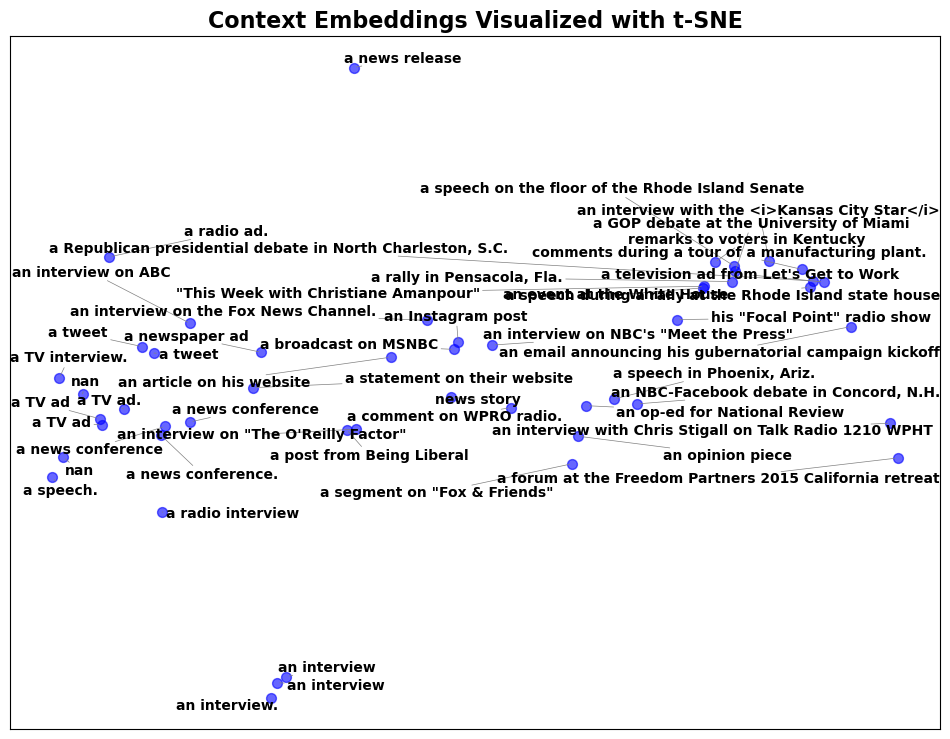

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

# Extract the embeddings and context after filtering
embeddings_filtered = np.array(test_data['context_embedding'].tolist())
context_filtered = test_data['context'].values  # Use 'context' instead of embeddings for text annotations

# Reduce the dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d_tsne_filtered = tsne.fit_transform(embeddings_filtered)

# Sample a subset of the data for clearer visualization
subset_size = 50  # Reduce the subset size for clarity and performance
indices = np.random.choice(range(len(embeddings_2d_tsne_filtered)), size=subset_size, replace=False)

# Create a scatter plot of the embeddings
plt.figure(figsize=(12, 9))  # Set figure size
plt.scatter(embeddings_2d_tsne_filtered[indices, 0], embeddings_2d_tsne_filtered[indices, 1], c='blue', s=50, alpha=0.6)

# Annotate the points with context for the subset
texts = []
for i in indices:
    texts.append(plt.text(embeddings_2d_tsne_filtered[i, 0], embeddings_2d_tsne_filtered[i, 1], context_filtered[i],
                          fontsize=10, ha='center', fontweight='bold'))

# Use adjustText to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Set title and axis labels
plt.title('Context Embeddings Visualized with t-SNE', fontsize=16, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.show()


Build a basic ML model with the current features and evaluate its performance.

In [172]:
train_data

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,context,processed_text,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded,context_embedding
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,a mailer,"[say, annies, list, political, group, support,...","[state, representative]",[abortion],[texas],[mailer],"[0.014797329902648926, -0.06205372512340546, -...","[0.005253844894468784, -0.04932749271392822, -...",19,"[-0.058597416, 0.0035566133, -0.03523096, -0.0..."
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,a floor speech.,"[decline, coal, start, started, natural, gas, ...","[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.016704915091395378, -0.09284275770187378, -...","[0.0008680796017870307, -0.030714131891727448,...",5,"[-0.028936552, -0.0030246174, -0.004101715, -0..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,Denver,"[hillary, clinton, agrees, john, mccain, votin...",[president],[foreign-policy],[illinois],[denver],"[0.023280462250113487, -0.09337124973535538, -...","[0.022212853655219078, -0.08951827138662338, -...",5,"[-0.08511545, -0.014303114, -0.021155512, -0.0..."
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,a news release,"[health, care, reform, legislation, likely, ma...",[],[health-care],[],"[news, release]","[0.019651882350444794, -0.08325517177581787, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.028034374, -0.00049205666, 0.030786872, 0...."
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,an interview on CNN,"[economic, turnaround, started, end, term]",[],"[economy, job]",[florida],"[interview, cnn]","[0.02371888794004917, -0.08580756187438965, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,"[-0.038219146, 0.004867751, -0.009428377, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,...,"interview on ""The Colbert Report""","[larger, number, shark, attack, florida, case,...",[],"[animal, election]",[florida],"[interview, colbert, report]","[0.01699431799352169, -0.09098586440086365, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.012361946, -1.3240488e-06, 0.025891144, 0...."
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,...,an interview,"[democrat, become, party, atlanta, metro, area...",[],[election],[georgia],[interview],"[0.019237203523516655, -0.0876646414399147, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[0.00090894586, -0.0050764135, -0.0023033824, ..."
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,...,a Republican presidential debate,"[say, alternative, social, security, operates,...",[],"[retirement, social-security]",[georgia],"[republican, presidential, debate]","[0.019512038677930832, -0.08380526304244995, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[-0.039133973, -0.0054789, -0.0072881626, -0.0..."
10236,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,...,a televised debate on Miami's WPLG-10 against ...,"[lifting, cuban, embargo, allo

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [43]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(train_data['subject_embedding'].values),
    np.vstack(train_data['job_title_embedding'].values),
    np.vstack(train_data['context_embedding'].values)
])
X_train_combined = np.hstack([X_train, X_embeddings])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])

X_valid = valid_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(valid_data['subject_embedding'].values),
    np.vstack(valid_data['job_title_embedding'].values),
    np.vstack(valid_data['context_embedding'].values)
])
X_valid_combined = np.hstack([X_valid, X_embeddings])
label_encoder = LabelEncoder()
y_valid = label_encoder.fit_transform(valid_data['label'])


X_test = test_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(test_data['subject_embedding'].values),
    np.vstack(test_data['job_title_embedding'].values),
    np.vstack(test_data['context_embedding'].values)
])
X_test_combined = np.hstack([X_test, X_embeddings])
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_data['label'])


# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_valid_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['true', 'true', 'false', ..., 'true', 'true', 'true'], dtype=object)

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'max_depth': np.arange(5, 25, 2),
    'min_samples_split': np.arange(5, 100, 10),
    'min_samples_leaf': np.arange(5, 50, 5),
                 }

def hyperparameter_range(param_values, param_name, clf_name):
    # get scores
    scores_accuracy = []
    scores_auc_roc = []
    scores_precision = []

    for param_value in param_values:
        # Create a classifier with the current hyperparameter value
        params = {param_name: param_value}
        if clf_name == 'sv':
            classifier = svm.SVC(**params, random_state=1, probability= True)
        elif clf_name == 'dt':
            classifier = DecisionTreeClassifier(**params, random_state=1)
        elif clf_name == 'rf':
            classifier = RandomForestClassifier(**params, random_state=1)
        elif clf_name == 'catboost':
            classifier = CatBoostClassifier(**params, verbose=False, random_state=1)

        # resample data using balancing method
        #b_method = balancing_clf_dict[clf_name]
        #balance = balancing_methods[b_method]

        # build pipeline
        steps = [#('balance', balance),
                 ('classifier', classifier)]
        pipeline = Pipeline(steps=steps)

        # Evaluate pipeline
        scores = cross_validate(pipeline, X_train, y_resampled, scoring=['accuracy', 'roc_auc', 'precision'], cv=cv)

        score_accuracy = np.mean(scores['test_accuracy'])
        score_auc_roc = np.mean(scores['test_roc_auc'])
        score_precision = np.mean(scores['test_precision'])

        scores_accuracy.append(score_accuracy)
        scores_auc_roc.append(score_auc_roc)
        scores_precision.append(score_precision)

    fig, axes = plt.subplots(3, 1, figsize=(6, 8))

    # Plot accuracy
    axes[0].plot(param_values, scores_accuracy, marker='o', label='Validation')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy as a function of ' + param_name)

    # Plot AUC-ROC
    axes[1].plot(param_values, scores_auc_roc, marker='o', label='Validation')
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('AUC-ROC')
    axes[1].set_title('AUC-ROC as a function of ' + param_name)

    # Plot precision
    axes[2].plot(param_values, scores_precision, marker='o', label='Validation')
    axes[2].set_xlabel(param_name)
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision as a function of ' + param_name)

    plt.tight_layout()
    return plt.show(), scores_auc_roc, scores_accuracy

In [ ]:

max_auc_param_rf={}
for parameter in rf_param_grid:
    figure, vec_auc, vec_acc = hyperparameter_range(rf_param_grid[parameter], parameter, 'rf')
    # Sort the vector in descending order
    sorted_indices = np.argsort(vec_auc)[::-1]
    sorted_param = np.array(rf_param_grid[parameter])[sorted_indices]
    max_auc_param_rf[parameter]=sorted_param[:3]
max_auc_param_rf


#print parameters currently in use
rf = RandomForestClassifier(random_state=1)
print('Parameters currently in use in RF:\n')
print(rf.get_params())
#Define parameter grids for RF
rf_param_grid = {
      'classifier__n_estimators': max_auc_param_rf['n_estimators'][:2],
      'classifier__min_samples_split': max_auc_param_rf['min_samples_split'],
      'classifier__min_samples_leaf': max_auc_param_rf['min_samples_leaf'],
      'classifier__max_depth': max_auc_param_rf['max_depth']
  }
print(rf_param_grid)
#get the best sv model
best_rf, best_params_rf, score_df_large_rf, grid_search_rf = get_best_model('rf', rf_param_grid)
best_classifiers['rf'] = best_rf
score_df_large_rf

accuracy 0.27071823204419887
(row=expected, col=predicted)


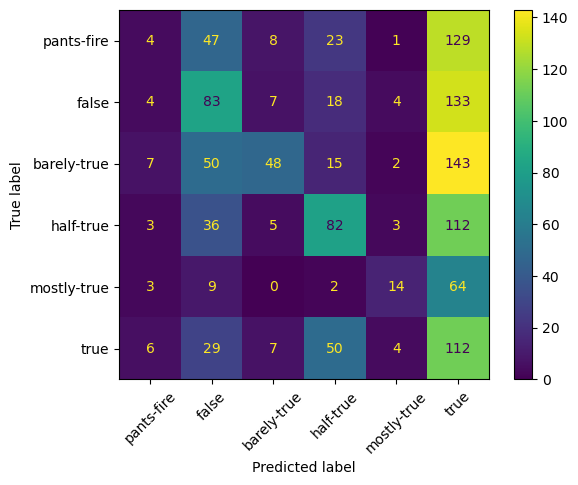

In [34]:
from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(train_data['statement'])
statements_bow = bow_transformer.transform(train_data['statement'])
tfidf_transformer = TfidfTransformer().fit(statements_bow)

bow_transformer.transform(train_data['statement'])
statements_tfidf = tfidf_transformer.transform(statements_bow)

In [36]:
%time fake_detector = MultinomialNB().fit(statements_tfidf, train_data['label'])
all_predictions =fake_detector.predict(statements_tfidf)

all_predictions

CPU times: total: 31.2 ms
Wall time: 36.6 ms


array(['false', 'half-true', 'half-true', ..., 'half-true', 'false',
       'false'], dtype='<U11')

In [37]:
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['tfidf'] = label_encoder.fit_transform(all_predictions)


In [38]:
train_data['tfidf']

0        1
1        2
2        2
3        1
4        2
        ..
10233    1
10234    3
10235    2
10236    1
10237    1
Name: tfidf, Length: 10238, dtype: int64

In [39]:
#add TF-IDF to test

bow_transformer_test = CountVectorizer(analyzer=preprocess_text).fit(test_data['statement'])
statements_bow_test = bow_transformer_test.transform(test_data['statement'])
tfidf_transformer_test = TfidfTransformer().fit(statements_bow_test)

bow_transformer_test.transform(test_data['statement'])
statements_tfidf_test = tfidf_transformer_test.transform(statements_bow_test)

In [40]:
%time fake_detector_test = MultinomialNB().fit(statements_tfidf_test, test_data['label'])
all_predictions_test =fake_detector_test.predict(statements_tfidf_test)

all_predictions_test

CPU times: total: 0 ns
Wall time: 8.07 ms


array(['false', 'false', 'false', ..., 'barely-true', 'barely-true',
       'mostly-true'], dtype='<U11')

In [41]:
test_data['tfidf'] = label_encoder.fit_transform(all_predictions_test)

In [42]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(train_data['subject_embedding'].values),
    np.vstack(train_data['job_title_embedding'].values),
    np.vstack(train_data['context_embedding'].values)
])
X_train_combined = np.hstack([X_train, X_embeddings])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])


X_test = test_data.select_dtypes(include=['number']).copy()
X_embeddings = np.hstack([
    np.vstack(test_data['subject_embedding'].values),
    np.vstack(test_data['job_title_embedding'].values),
    np.vstack(test_data['context_embedding'].values)
])
X_test_combined = np.hstack([X_test, X_embeddings])
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_data['label'])


# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_test_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['false', 'false', 'false', ..., 'barely-true', 'barely-true',
       'false'], dtype=object)

accuracy 0.3835832675611681
(row=expected, col=predicted)


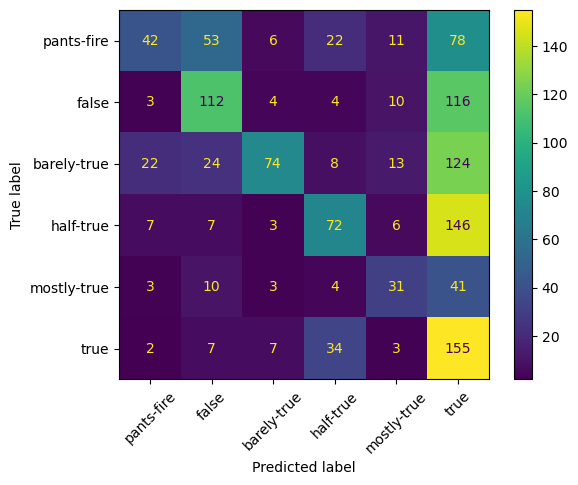

In [43]:
from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')

# Topic Modeling with LDA
This section handles topic modeling using LDA (Latent Dirichlet Allocation).

In [44]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

# Create a dictionary and corpus for the LDA model
dictionary = corpora.Dictionary(train_data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in train_data['processed_text']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=20)

# Display the topics discovered by the model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)
    
    


(0, '0.033*"health" + 0.030*"care" + 0.020*"say" + 0.013*"law" + 0.013*"gun" + 0.012*"insurance" + 0.010*"obama" + 0.010*"security" + 0.009*"people" + 0.009*"american"')
(1, '0.040*"say" + 0.014*"clinton" + 0.013*"republican" + 0.010*"trump" + 0.009*"hillary" + 0.009*"vote" + 0.008*"democrat" + 0.008*"donald" + 0.008*"said" + 0.007*"president"')
(2, '0.046*"percent" + 0.019*"tax" + 0.017*"state" + 0.016*"year" + 0.013*"rate" + 0.009*"family" + 0.008*"people" + 0.007*"average" + 0.007*"country" + 0.007*"say"')
(3, '0.013*"city" + 0.013*"school" + 0.013*"say" + 0.012*"state" + 0.010*"tax" + 0.010*"people" + 0.010*"one" + 0.010*"county" + 0.009*"year" + 0.007*"gas"')
(4, '0.017*"say" + 0.015*"scott" + 0.013*"wisconsin" + 0.013*"gov" + 0.013*"state" + 0.011*"public" + 0.009*"voting" + 0.009*"walker" + 0.007*"rick" + 0.007*"voter"')
(5, '0.021*"say" + 0.020*"job" + 0.016*"year" + 0.016*"tax" + 0.016*"state" + 0.013*"obama" + 0.013*"billion" + 0.012*"president" + 0.011*"budget" + 0.010*"cut"

In [45]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization as an HTML file
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

# Optionally, you can open it directly in the browser
import webbrowser
webbrowser.open('lda_visualization.html')

True

label           barely-true  false  half-true  mostly-true  pants-fire  true
dominant_topic                                                              
0                       246    325        257          214         156   201
1                       262    357        309          273         157   249
2                       268    314        458          521         111   422
3                       183    225        224          242          86   206
4                       185    226        203          178         110   156
5                       510    546        663          534         219   442


<Axes: xlabel='dominant_topic'>

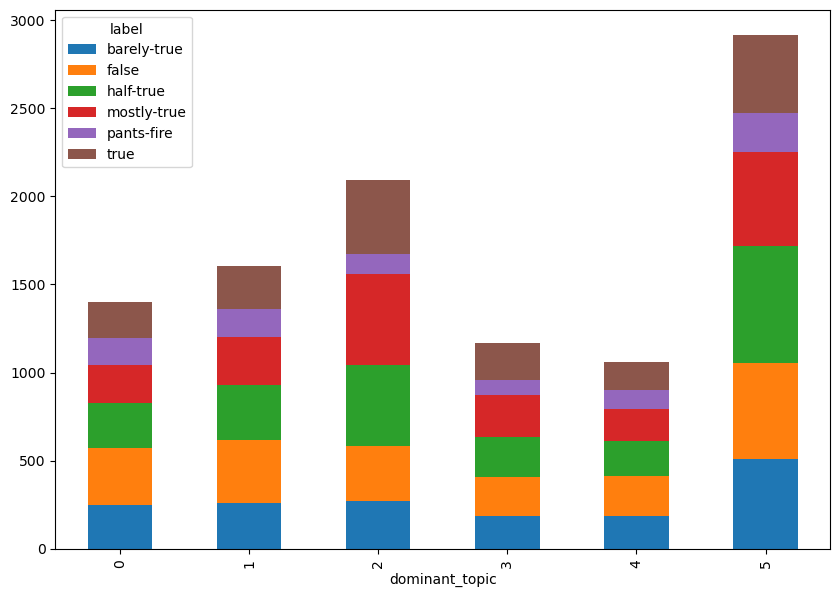

In [47]:

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Display the distribution
print(label_distribution_by_topic)

# Optionally, you can visualize the distribution using a bar chart
label_distribution_by_topic.plot(kind='bar', stacked=True, figsize=(10, 7))


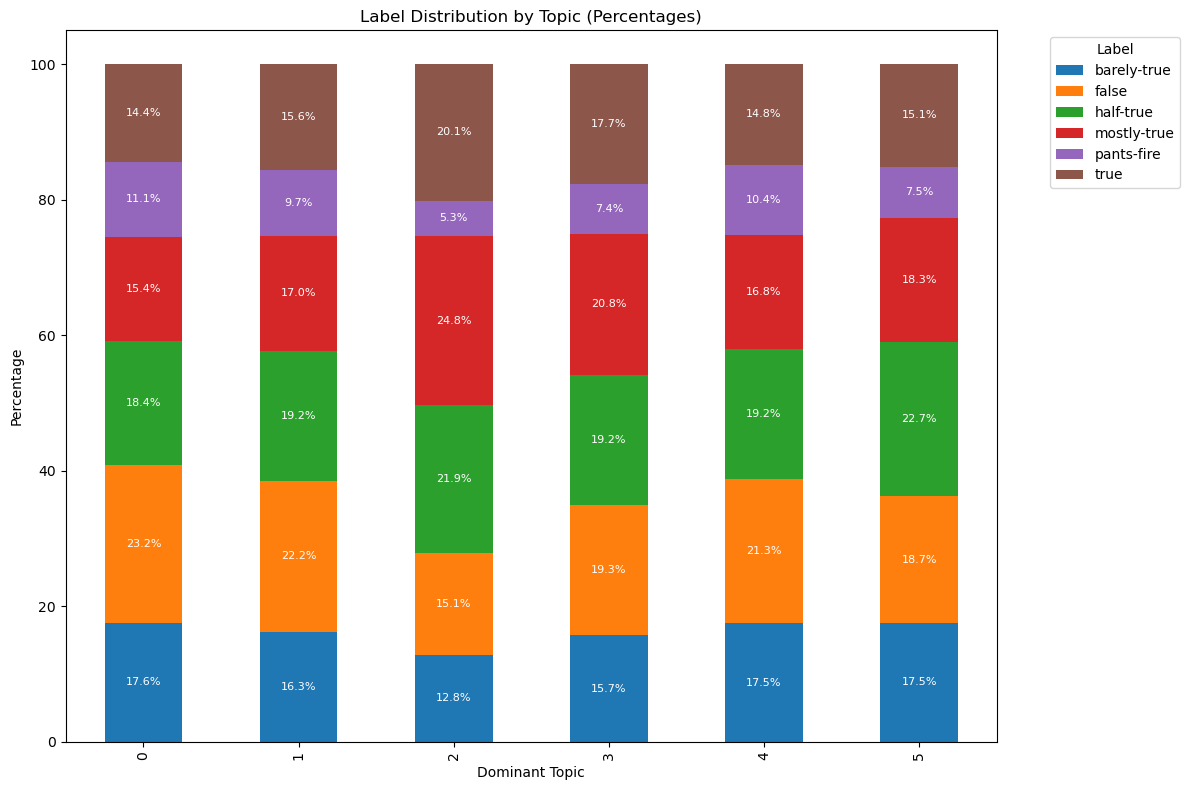

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Calculate the percentage distribution within each topic
label_distribution_percentages = label_distribution_by_topic.div(label_distribution_by_topic.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
fig, ax = plt.subplots(figsize=(12, 8))
label_distribution_percentages.plot(kind='bar', stacked=True, ax=ax)

# Add percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only label non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='white')

# Move the legend outside the plot
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Label Distribution by Topic (Percentages)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

In [50]:
# add the dominant topic to each sample of the train data
import pandas as pd
import numpy as np

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Display the first few rows of the updated DataFrame to verify the result
display(train_data)

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,...,processed_job_title,processed_subject,processed_state,processed_context,subject_embedding,job_title_embedding,party_encoded,context_embedding,tfidf,dominant_topic
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,"[state, representative]",[abortion],[texas],[mailer],"[0.018180008977651596, -0.0631868988275528, -0...","[0.006621419917792082, -0.04711318761110306, -...",19,"[-0.056171212, 0.0076454207, -0.04661427, -0.0...",1,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,"[state, delegate]","[energy, history, job-accomplishments]",[virginia],"[floor, speech]","[0.020820951089262962, -0.08923283964395523, -...","[0.0016404485795646906, -0.02940816804766655, ...",5,"[-0.028172664, 0.006852841, -0.012942183, -0.0...",2,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,[president],[foreign-policy],[illinois],[denver],"[0.029917191714048386, -0.09946512430906296, -...","[0.02458118088543415, -0.08566904067993164, -0...",5,"[-0.08472326, 0.020879442, -0.031421535, -0.00...",2,4
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,[],[health-care],[],"[news, release]","[0.02287386916577816, -0.08189141750335693, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.025726834, 0.001143941, 0.02290306, -4.841...",1,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,[],"[economy, job]",[florida],"[interview, cnn]","[0.026751399040222168, -0.08228014409542084, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,"[-0.022444539, 0.004624348, 0.022549277, -0.00...",2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10233,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,...,[],"[animal, election]",[florida],"[interview, colbert, report]","[0.021239977329969406, -0.08938449621200562, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,"[-0.024320904, -0.0046115965, 0.02896068, 0.01...",1,1
10234,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,...,[],[election],[georgia],[interview],"[0.023354357108473778, -0.08586359024047852, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[-0.0016388154, -0.0050009545, -0.0022342426, ...",3,0
10235,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,...,[],"[retirement, social-security]",[georgia],"[republican, presidential, debate]","[0.022153319790959358, -0.07834595441818237, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,"[-0.03294536, 0.00027256447, -0.010587208, -0....",2,0
10236,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,...,[],"[florida, foreign-policy]",[florida],"[televised, debate, miami, wplg-10, kendrick, ...","[0.022692933678627014, -0.08407224714756012, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,"[-0.09231996, 0.023943387, -0.005277267, -0.03...",1,0


In [55]:
# Add the dominant topic to the dataset as a numerical feature
train_data['dominant_topic'] = dominant_topics

# Repeat the same for the test data
corpus_test = [dictionary.doc2bow(text) for text in test_data['processed_text']]
topic_distributions_test = lda_model.get_document_topics(corpus_test, minimum_probability=0)

dominant_topics_test = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions_test]
test_data['dominant_topic'] = dominant_topics_test


In [56]:
# Ensure the dominant topic is correctly added
train_data['dominant_topic'] = dominant_topics
test_data['dominant_topic'] = dominant_topics_test

# Check if the shapes align before moving forward
print("Train shape after adding dominant topic:", train_data.shape)
print("Test shape after adding dominant topic:", test_data.shape)


Train shape after adding dominant topic: (10238, 25)
Test shape after adding dominant topic: (1267, 25)


In [57]:
# Combine the dominant topic with other numerical features
X_train = train_data.select_dtypes(include=['number']).copy()
X_test = test_data.select_dtypes(include=['number']).copy()

# Since 'dominant_topic' is already numerical, we don't need to embed it.
# Ensure it is included in the training and test sets.
X_train_combined = X_train.values
X_test_combined = X_test.values

# Encode the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the trained model
all_predictions = model.predict(X_test_combined)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Calculate the accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.78


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Accuracy: 0.7829518547750592
(row=expected, col=predicted)


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

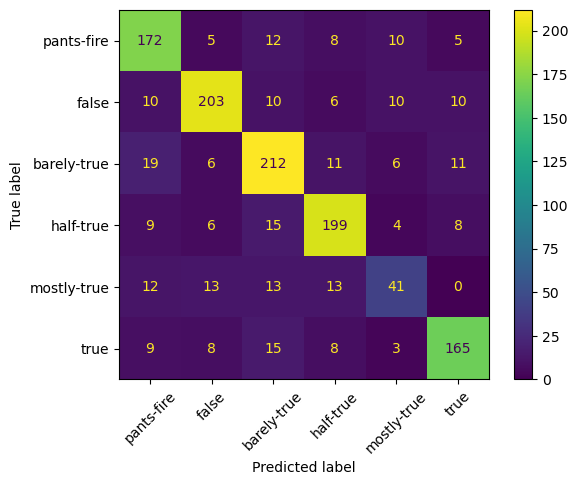

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define the labels
my_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(test_data['label'], predicted_labels, labels=my_labels)

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=test_data['label'], 
    y_pred=predicted_labels, 
    display_labels=my_labels, 
    xticks_rotation=45
)

# Print additional information about the confusion matrix
print('(row=expected, col=predicted)')
